In [ ]:
import torch
import torch.nn as nn
from torchvision import models

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [2]:
# Create transformations for training dataset
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [3]:
# Create transformations for eval and test datasets
eval_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [4]:
# Load train/eval/test datasets and apply transformations
train_dataset = ImageFolder(
    root="../data/train",
    transform=train_transforms
)

val_dataset = ImageFolder(
    root="../data/val",
    transform=eval_transforms
)

test_dataset = ImageFolder(
    root="../data/test",
    transform=eval_transforms
)

In [5]:
train_dataset.class_to_idx

{'NORMAL': 0, 'PNEUMONIA': 1}

In [6]:
# create DataLoaders for train, val, and test datasets
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

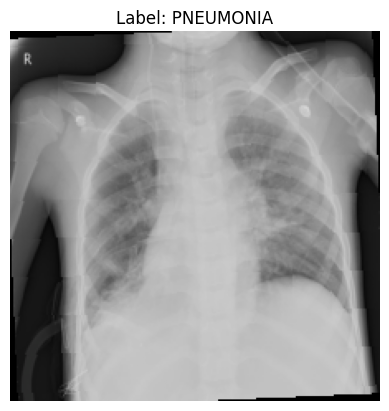

In [7]:
# Get images and labels from train dataset batch
images, labels = next(iter(train_loader))

# Undo normalization for visualization
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

img = images[0] * std + mean
img = img.permute(1, 2, 0)

plt.imshow(img)
plt.title(f"Label: {train_dataset.classes[labels[0]]}")
plt.axis("off")
plt.show()

#### MODEL TRAINING

In [ ]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [9]:
# Load pretrained ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze all backbone parameters
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer (fc) for binary classification
# Output 1 logit -> use BCEWithLogitsLoss
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)

# Move model to device
model = model.to(device)

In [10]:
# Binary Cross-Entropy with Logits
criterion = nn.BCEWithLogitsLoss()

# Only train the last fc layer
optimizer = torch.optim.Adam(
    model.fc.parameters(),
    lr=0.001
)

In [11]:
def run_epoch(model, loader, criterion, optimizer=None):
    training = optimizer is not None
    model.train() if training else model.eval()

    epoch_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(loader):
        # Move to device
        images = images.to(device)
        labels = labels.float().to(device)

        # Forward pass
        outputs = model(images).squeeze(1)
        loss = criterion(outputs, labels)

        if training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Compute accuracy
        preds = (torch.sigmoid(outputs) > 0.5)
        correct += (preds == labels.bool()).sum().item()
        total += labels.size(0)
        epoch_loss += loss.item() * labels.size(0)

        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx+1}/{len(loader)}")

    return epoch_loss / total, correct / total


In [12]:
num_epochs = 5  # adjust as needed

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Training
    train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # Validation
    val_loss, val_acc = run_epoch(model, val_loader, criterion)
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")



Epoch 1/5
Batch 1/163
Batch 101/163
Train Loss: 0.3376, Train Acc: 0.8593
Batch 1/1
Val Loss: 0.3968, Val Acc: 0.7500

Epoch 2/5
Batch 1/163
Batch 101/163
Train Loss: 0.2065, Train Acc: 0.9224
Batch 1/1
Val Loss: 0.2838, Val Acc: 0.8125

Epoch 3/5
Batch 1/163
Batch 101/163
Train Loss: 0.1860, Train Acc: 0.9266
Batch 1/1
Val Loss: 0.3335, Val Acc: 0.8125

Epoch 4/5
Batch 1/163
Batch 101/163
Train Loss: 0.1598, Train Acc: 0.9398
Batch 1/1
Val Loss: 0.4517, Val Acc: 0.6875

Epoch 5/5
Batch 1/163
Batch 101/163
Train Loss: 0.1556, Train Acc: 0.9417
Batch 1/1
Val Loss: 0.3206, Val Acc: 0.8125


In [13]:
# save the trained model
torch.save(model.state_dict(), "resnet18_chestxray.pth")